# Titanic Survival with DNN

**Predicting survival on the Titanic using an artificial neural network in Keras**


**Supervised Learning. Binary classification**


This project is based on a dataset containing demographics and passenger information from 891 of the 2224 passengers and crew on board the Titanic. A description of this dataset is on the [Kaggle website](https://www.kaggle.com/c/titanic/data), where the data was obtained.

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import helper
#%reload_ext helper
import keras

helper.info_gpu()
helper.reproducible(seed=0) # Setup reproducible results from run to run using Keras

Using TensorFlow backend.


/device:GPU:0
Keras		v2.1.3
TensorFlow	v1.4.1


## 1. Data Processing and Exploratory Data Analysis

In [2]:
data_path = 'data/titanic_data.csv'
target = ['Survived']  # the target will remain the same throughout the notebook

df_original = pd.read_csv(data_path)
print("{} rows \n{} columns \ntarget: {}".format(*df_original.shape, target))

891 rows 
12 columns 
target: ['Survived']


### Show original data

In [3]:
df_original.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


#### Numerical Data

In [4]:
df_original.describe(percentiles=[0.5])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### Non-numerical Data

In [5]:
df_original.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Connors, Mr. Patrick",male,347082,G6,S
freq,1,577,7,4,644


#### Missing values

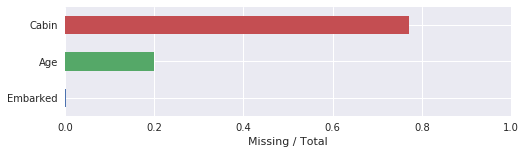

In [6]:
helper.missing(df_original)

- Binary target "Survived": ~38% ones; F1 score won't be used <br>
- Some values are missing for key values (e.g. Age)
- Some features (e.g. PassengerID, Name, Ticket) seem irelevant to survival probabilities <br> 

### Transform the data

#### Enhance and add new features

In [7]:
df = df_original.copy()  # modified dataset


def enhance_features(df, dict_categories=None):
    """ Enhance dataframe df """

    df = df.copy()
        
    # filter Cabin to first letter
    df["Cabin"] = df["Cabin"].str[0]

    # get Title from Name
    df['Title'] = df["Name"].str.extract('([A-Za-z]+)\.', expand=False)

    # remove low frequency values for the new feautres
    fields = ['Cabin', 'Title']
    df, dict_categories = helper.remove_categories(df, target=target, show=False)

    # Alone passenger
    df['Alone'] = ((df["SibSp"] + df["Parch"]) == 0).astype(int)
    
    return df, dict_categories


df, dict_categories = enhance_features(df)

Non-numerical fields changed to 'category': ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Title']


#### Remove irrelevant features

In [8]:
def drop_irrelevant_features(df, inplace=False):
    """ Remove non-relevant columns from dataftame df (inplace) """
    
    if not inplace:
        df = df.copy()
        
    df.drop(['PassengerId', 'Name', 'Ticket'], axis='columns', inplace=True)

    if not inplace:
        return df

    
drop_irrelevant_features(df, inplace=True)

#### Classify variables

Change categorical variables as dtype 'categorical' and sort columns: numerical + categorical + target

In [9]:
df = helper.classify_data(df, target, numerical=["Age", "SibSp", "Parch", "Fare"])

pd.DataFrame(dict(df.dtypes), index=["Type"])[df.columns].head() # show data types

numerical features:   4
categorical features: 6
target 'Survived': category


,Age,SibSp,Parch,Fare,Pclass,Sex,Cabin,Embarked,Title,Alone,Survived
Type,float32,float32,float32,float32,category,category,category,category,category,category,category


### Visualize the data

#### Categorical features

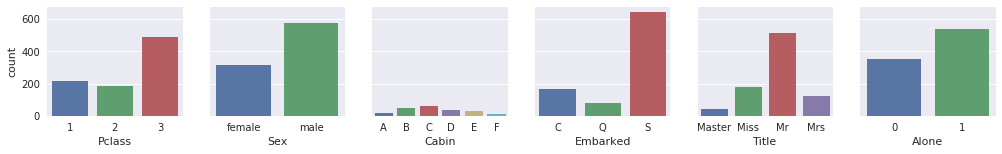

In [10]:
helper.show_categorical(df, target=target, sharey=True)

#### Target vs Categorical features

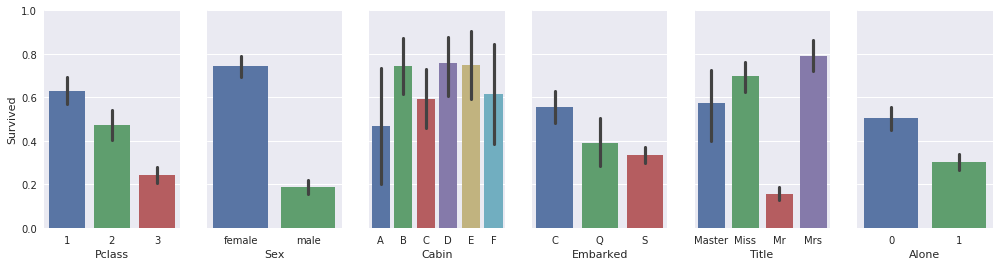

In [11]:
helper.show_target_vs_categorical(df, target)
plt.ylim([0, 1]);

#### Numerical features

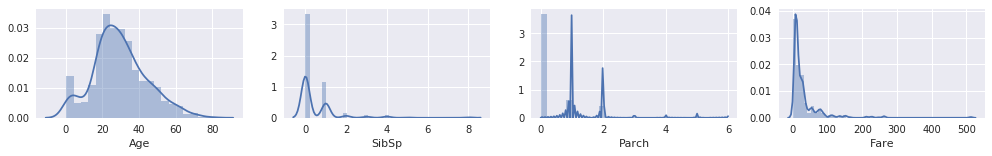

In [12]:
helper.show_numerical(df, kde=True)

#### Target vs numerical features

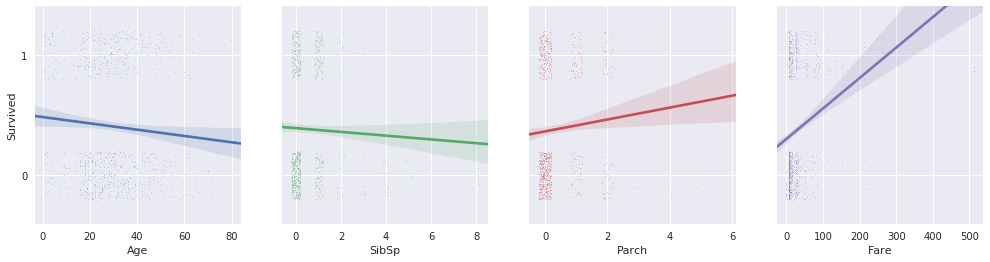

In [13]:
helper.show_target_vs_numerical(df, target, jitter=0.2)
plt.ylim([-0.4, 1.4])
plt.yticks([0, 1]);
#df.groupby('Survived')['Age'].hist(alpha=0.4)
# helper.show_target_vs_numerical(df_3sigma, target, numerical, jitter=0.2)

#### Correlation between numerical features and target

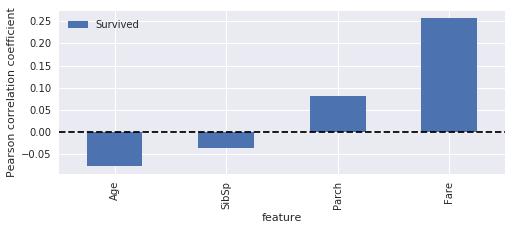

In [14]:
helper.show_correlation(df, target)

#### Most relevant features

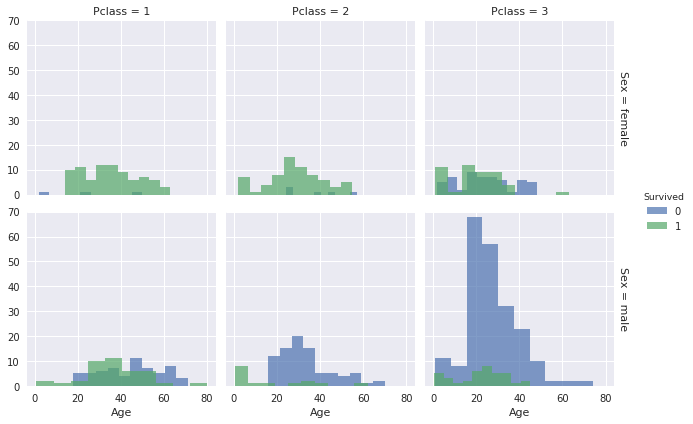

In [15]:
sns.FacetGrid(
    df, row="Sex", col="Pclass", hue="Survived", size=3, margin_titles=True).map(
        plt.hist, "Age", alpha=.7).add_legend()
plt.ylim([0, 70]);
# df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean().sort_values(
#     by='Survived', ascending=False)
# helper.show_target_vs_categorical(df.loc[(df['Age']<12) | (df['Sex']=='female')],
#                                   target, categorical)

-  Unlike in third class, most children and women in first and second classes survived.

### Fill missing values

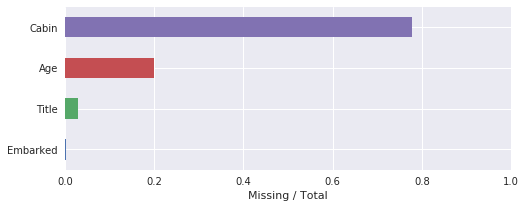

In [16]:
helper.missing(df)

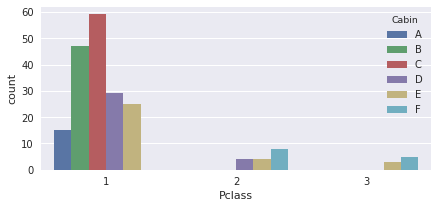

In [17]:
plt.figure(figsize=(7, 3))
sns.countplot(data=df, x='Pclass', hue='Cabin');

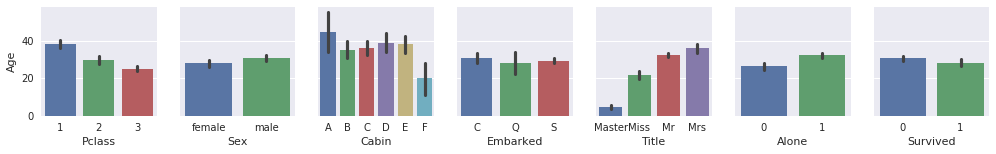

In [18]:
helper.show_target_vs_categorical(df, ['Age'], figsize=(17, 2))  # Age vs categorical

In [19]:
def fill_missing_values(df, inplace=False):
    """ Fill missing values of the dataframe df """

    if not inplace:
        df = df.copy()

    # fill Embarked with mode
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    
    # fill Cabin: the mode for grouped Pclass and Embarked  
    ref = df.groupby(['Pclass', 'Embarked'])['Cabin'].transform(lambda x: x.mode()[0])
    df['Cabin'].fillna(ref.iloc[0], inplace=True)
        
    # fill Age: the median for grouped Pclass and Title
    ref = df.groupby(['Pclass', 'Title'])['Age'].transform('median')
    df['Age'].fillna(ref, inplace=True)

    # fill Title: by age and sex only (not spouse or job)
    # df.loc[df['Title']=='Master','Age'].unique()
#     for idx, row in df.iterrows():
#         if (pd.isnull(row['Title'])):
#             if row['Age'] >= 13:
#                 if row['Sex'] == 'male':
#                     df.loc[idx, 'Title'] = "Mr"
#                 else:
#                     df.loc[idx, 'Title'] = "Mrs"
#             else:
#                 if row['Sex'] == 'male':
#                     df.loc[idx, 'Title'] = "Master"
#                 else:
#                     df.loc[idx, 'Title'] = "Miss"     
    
    # fill missing categorical values with the mode (if any)
    categorical = list(df.select_dtypes(include=['category']))
    modes = df[categorical].mode()  # this solves fillna issue with mode()
    for idx, f in enumerate(df[categorical]):
        df[f].fillna(modes.iloc[0, idx], inplace=True)

    # fill missing numeric NaN values with the median (if any)
    df.fillna(df.median(), inplace=True)

    if not inplace:
        return df


# bins = list(range(0,80,10))
# # bins = (0, 5, 10, 15, 20, 30, 40, 50, 60)
# labels = ["{}-{}".format(i, j) for i,j in zip(bins[:-1],bins[:-1])]
# df['Age_cat'] = pd.cut(df['Age'], bins, labels=labels).astype('category')
# df = df.drop(['Age'], axis='columns')

fill_missing_values(df, inplace=True)

## 2. Neural Network model

### Select the features for the model

In [20]:
droplist = []  # features to drop from the model

# For the model 'data' instead of 'df'
data = df.copy()
df.drop(droplist, axis='columns', inplace=True)
data.head(3)

,Age,SibSp,Parch,Fare,Pclass,Sex,Cabin,Embarked,Title,Alone,Survived
0,22.0,1.0,0.0,7.250000,3,male,E,S,Mr,0,0
1,38.0,1.0,0.0,71.283302,1,female,C,C,Mrs,0,1
2,26.0,0.0,0.0,7.925000,3,female,E,S,Miss,1,1


### Scale numerical variables

Shift and scale numerical variables to a standard normal distribution. The scaling factors are saved to be used for predictions.

In [21]:
data, scale_param = helper.scale(data)

### Create dummy features

Replace categorical features (no target) with dummy features

In [22]:
data, dict_dummies = helper.replace_by_dummies(data, target)

model_features = [f for f in data if f not in target] # sorted neural network inputs

data.head(3)

,Age,SibSp,Parch,Fare,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,...,Cabin_F,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Alone_0,Alone_1
0,-0.528175,0.432550,-0.473408,-0.502163,0,0,0,1,0,1,...,0,0,0,1,0,0,1,0,1,0
1,0.658128,0.432550,-0.473408,0.786404,1,1,0,0,1,0,...,0,1,0,0,0,0,0,1,1,0
2,-0.231600,-0.474279,-0.473408,-0.488580,1,0,0,1,1,0,...,0,0,0,1,0,1,0,0,0,1


### Split the data into training and test sets
Data leakage: Test set hidden when training the model, but seen when preprocessing the dataset

In [23]:
from sklearn.model_selection import train_test_split


def split(data, target, test_size=0.15):
    train, test = train_test_split(data, test_size=test_size, random_state=9, 
                                  stratify=data[target])

    # Separate the data into features and target (x=features, y=target)
    x_train, y_train = train.drop(target, axis=1).values, train[target].values
    x_test, y_test = test.drop(target, axis=1).values, test[target].values
    # _nc: non-categorical yet (needs one-hot encoding)

    return x_train, y_train, x_test, y_test


x_train, y_train, x_test, y_test = split(data, target, test_size=0.2)

### One-hot encode the output

In [24]:
def one_hot_output(y_train, y_test):
    
    num_classes = len(np.unique(y_train))
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    return y_train, y_test


y_train, y_test = one_hot_output(y_train, y_test)

print("train size \t X:{} \t Y:{}".format(x_train.shape, y_train.shape))
print("test size  \t X:{} \t Y:{} ".format(x_test.shape, y_test.shape))

train size 	 X:(712, 24) 	 Y:(712, 2)
test size  	 X:(179, 24) 	 Y:(179, 2) 


### Build the Neural Network for Binary Classification

In [25]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout


def build_nn(input_size, output_size, summary=False):

    input_nodes = input_size
    weights = keras.initializers.RandomNormal(stddev=0.001)
    leaky_relu = keras.layers.advanced_activations.LeakyReLU(alpha=0.01)

    model = Sequential()
    model.add(
        Dense(
            input_nodes,
            input_dim=input_size,
            kernel_initializer=weights,
            activation='relu',
            bias_initializer='zero'))
    model.add(leaky_relu)

    model.add(Dropout(.3))

    model.add(
        Dense(
            output_size,
            activation='softmax',
            kernel_initializer=weights,
            bias_initializer='zero'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    if summary:
        model.summary()

    return model


model = build_nn(x_train.shape[1], y_train.shape[1], summary=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 50        
Total params: 650
Trainable params: 650
Non-trainable params: 0
_________________________________________________________________


### Train the Neural Network

Training ....
time: 	 1.0 s


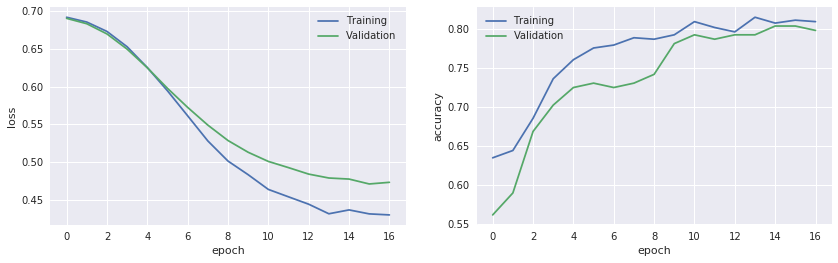


Training loss:  	0.4299
Validation loss: 	0.4731

Training accuracy: 	0.809
Validation accuracy:	0.798

Model saved at models/titanic.h5


In [26]:
from time import time
model_path = os.path.join("models", "titanic.h5")


def train_nn(model, x_train, y_train, validation_data=None, path=False, show=True):
    """ 
    Train the neural network model. If no validation_data is provided, a split for validation
    will be used
    """
    
    if show:
        print('Training ....')
    
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=0)]
    t0 = time()

    history = model.fit(
        x_train,
        y_train,
        epochs=1000,
        batch_size=64,
              
        verbose=0,
        validation_split=0.25,
        validation_data = validation_data,
        callbacks=callbacks)

    if show:
        print("time: \t {:.1f} s".format(time() - t0))
        helper.show_training(history)

    if path:
        model.save(path)
        print("\nModel saved at", path)
    
    return history
        

model = None
model = build_nn(x_train.shape[1], y_train.shape[1], summary=False)
train_nn(model, x_train, y_train, path=model_path);

### Train with Cross Validation

In [27]:
from sklearn.model_selection import StratifiedKFold


def cv_train_nn(x_train, y_train, n_splits):
    """ Create and Train models for cross validation. Return best model """

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

    score = []

    best_model = None
    best_acc = 0

    print('Training {} models for Cross Validation ...'.format(n_splits))

    for train, val in skf.split(x_train[:, 0], y_train[:, 0]):
        model = None
        model = build_nn(x_train.shape[1], y_train.shape[1], summary=False)
        history = train_nn(
            model,
            x_train[train],
            y_train[train],
            show=False,
            validation_data=(x_train[val], y_train[val]))

        val_acc = history.history['val_acc'][-1]

        score.append(val_acc)

        if val_acc > best_acc:  # save best model (fold) for evaluation and predictions
            best_model = model
            best_acc = val_acc

    model = best_model
    print('\nCross Validation accuracy: {:.3f}'.format(np.mean(score)))

    return best_model


model = cv_train_nn(x_train, y_train, 4)

Training 4 models for Cross Validation ...

Cross Validation accuracy: 0.809


### Evaluate the model

In [28]:
def evaluate_nn(model, x_test, y_test):
    score = model.evaluate(x_test, y_test, verbose=0)
    print("Test Accuracy: {:.3f}".format(score[1]))


#model = keras.models.load_model(model_path)
evaluate_nn(model, x_test, y_test)

Test Accuracy: 0.832


### Make predictions

In [29]:
def predict_manual(new_df):
    """
    input: custom dataframe 
    """
    
    new_data = new_df.copy()
    
    # force data types to previous dataframe df 
    for col in new_data:
        new_data[col] = new_data[col].astype(df.dtypes[col])
    
    # standardize numerical variables
    new_data, _ = helper.scale(new_data, scale_param)
    
    # replace categorical features by dummy variables (using existing dummies)
    new_data, _ = helper.replace_by_dummies(new_data, target, dict_dummies)

    # sort columns to match with manual entries
    new_data = new_data[model_features] ## model_features: sorted list used in the model

    # make predictions
    prediction = model.predict(new_data.values)[:, 1]
    return (prediction)


#     for index, row in new_data.iterrows():
#         single_pred = model.predict(np.array([row]))
#         print('{}:\t {:.0f}%'.format(index,single_pred[0,1] * 100))

In [30]:
# input data format
df.describe()

,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000
mean,29.123648,0.523008,0.381594,32.204208
std,13.487280,1.102744,0.806057,49.693428
min,0.420000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,7.910400
50%,26.000000,0.000000,0.000000,14.454200
75%,36.250000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329224


In [31]:
df.describe(include=['category'])

,Pclass,Sex,Cabin,Embarked,Title,Alone,Survived
count,891,891,891,891,891,891,891
unique,3,2,6,3,4,2,2
top,3,male,E,S,Mr,1,0
freq,491,577,724,646,544,537,549


In [32]:
print(list(df))

['Age', 'SibSp', 'Parch', 'Fare', 'Pclass', 'Sex', 'Cabin', 'Embarked', 'Title', 'Alone', 'Survived']


In [33]:
new_passengers = {
    'Average man':    [26, 1, 0, 14, 2, 'male',   'C', 'S', 'Mr', 0],
    'Average woman':  [26, 1, 0, 14, 2, 'female', 'C', 'S', 'Mrs', 0],
    'Alone woman 3c': [26, 0, 2, 8, 3, 'female',  'C', 'S', 'Miss', 1],
    'Boy 1c ':        [7, 0, 2, 31, 1, 'male',    'C', 'S', 'Master', 0],
    'Boy 2c ':        [7, 0, 2, 14, 2, 'male',    'C', 'S', 'Master', 0],
    'Boy 3c ':        [7, 0, 2, 8, 3, 'male',     'C', 'S', 'Master', 0],
}

# create a dataframe with the new data
new_df = pd.DataFrame(
    data=list(new_passengers.values()),
    index=new_passengers.keys(),
    columns= [f for f in list(df) if f not in target])

prediction = predict_manual(new_df)
new_df['Survival prob. (%)'] = (prediction * 100).astype(int)
new_df

,Age,SibSp,Parch,Fare,Pclass,Sex,Cabin,Embarked,Title,Alone,Survival prob. (%)
Average man,26,1,0,14,2,male,C,S,Mr,0,25
Average woman,26,1,0,14,2,female,C,S,Mrs,0,84
Alone woman 3c,26,0,2,8,3,female,C,S,Miss,1,53
Boy 1c,7,0,2,31,1,male,C,S,Master,0,75
Boy 2c,7,0,2,14,2,male,C,S,Master,0,66
Boy 3c,7,0,2,8,3,male,C,S,Master,0,44


The results predicted from the model confirm the impact of the sex for the survival probabilities, as well as the class for the survival of women and children.

### Compare with non-enhanced features

In [34]:
# Same dataset without:
#   enhancing features
#   adding new features
#   filling missing values using grouped median

def non_enhanced_pipeline(df):
    
    df = df.copy()

    # select features & classify features
    df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis='columns', inplace=True)
    df = helper.classify_data(df, target, numerical=["Age", "SibSp", "Parch", "Fare"])

    # fill NaN
    df.fillna(df.median(), inplace=True)

    # standardize and create dummies
    data, _ = helper.scale(df)
    data, _ = helper.replace_by_dummies(data, target)

    # split and one-hot output
    x_train, y_train, x_test, y_test = split(data, target, test_size=0.15)
    y_train, y_test = one_hot_output(y_train, y_test)

    # build, train and evaluate model
    model = build_nn(x_train.shape[1], y_train.shape[1], summary=False)
    train_nn(model, x_train, y_train, path=False, show=False)
    evaluate_nn(model, x_test, y_test)

    
non_enhanced_pipeline(df_original)    

numerical features:   4
categorical features: 3
target 'Survived': category
Test Accuracy: 0.858


### Compare removing outliers

In [35]:
def remove_outliers_peline(df):

    df = df.copy()

    # transform features
    df, dict_categories = enhance_features(df)

    # select features & classify features
    df.drop(['PassengerId', 'Name', 'Ticket'], axis='columns', inplace=True)
    df = helper.classify_data(df, target, numerical=["Age", "SibSp", "Parch", "Fare"])

    # remove outliers
    helper.remove_outliers(df, inplace=True)  # remove default values above 3 times std

    # fill missing values (enhanced)
    fill_missing_values(df, inplace=True)

    # standardize and create dummies
    data, _ = helper.scale(df)
    data, _ = helper.replace_by_dummies(data, target)

    # split and one-hot output
    x_train, y_train, x_test, y_test = split(data, target, test_size=0.15)
    y_train, y_test = one_hot_output(y_train, y_test)

    # build, train and evaluate model
    model = build_nn(x_train.shape[1], y_train.shape[1], summary=False)
    train_nn(model, x_train, y_train, path=False, show=False)
    evaluate_nn(model, x_test, y_test)


remove_outliers_peline(df_original)

Non-numerical fields changed to 'category': ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Title']
numerical features:   4
categorical features: 6
target 'Survived': category
['Age', 'SibSp', 'Parch', 'Fare']
Test Accuracy: 0.828


### Compare with non-neural network models

#### XGBoost

In [38]:
# import warnings
# warnings.filterwarnings("ignore")

helper.XGBClassifier(
    x_train, y_train[:,1], x_test, y_test[:,1], max_depth=4, n_estimators=400, learning_rate=0.1)


 XGBoost 
 --------------------
Test Accuracy:  	 0.827
Training Time:  	 173.6 ms


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=400, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

#### Classical Machine Learning

In [39]:
# enhanced features
helper.ml_classification(x_train, y_train[:,1], x_test, y_test[:,1])


 Naive Bayes 
 --------------------
Test Accuracy:  	 0.777
ROC_AUC: 		 0.781
Training Time:  	 1.7 ms

 Decision Tree 
 --------------------
Test Accuracy:  	 0.816
ROC_AUC: 		 0.802
Training Time:  	 2.3 ms

 KNeighbors 
 --------------------
Test Accuracy:  	 0.821
ROC_AUC: 		 0.859
Training Time:  	 1.3 ms

 AdaBoost 
 --------------------
Test Accuracy:  	 0.793
ROC_AUC: 		 0.846
Training Time:  	 66.3 ms

 Random Forest 
 --------------------
Test Accuracy:  	 0.849
ROC_AUC: 		 0.862
Training Time:  	 115.7 ms
